# Xgboost: with CPU and GPU support

(Also Comparison with random forest)

### Necessary libraries

In [1]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter

from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_absolute_error, f1_score, precision_score, recall_score
from sklearn.datasets import fetch_openml
from sklearn import preprocessing

import seaborn as sns
sns.set(context='notebook',
        style='whitegrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=True,
        rc=None)

# Data

In [3]:
%%time
mnist = fetch_openml("mnist_784")


X_train, X_test, train_labels, test_labels = train_test_split(mnist.data,
                            mnist.target,
                            train_size = 6/7,
                            stratify=mnist.target,
                            random_state=42)

y_train = train_labels.astype(int)
y_test = test_labels.astype(int)

classes = np.unique(mnist.target)   
print(mnist.data.shape)
print(X_train.shape)
print(X_test.shape)

(70000, 784)
(60000, 784)
(10000, 784)
Wall time: 20.5 s


# 1. Xgboost with CPU Support

### **Here I will be using Intel i5-8300H, 4 cores, 8 threads, 2.3 GHz** 

In [4]:
xgb_cpu = XGBClassifier(n_jobs = 4, learning_rate = 0.1, verbosity=1, booster='gbtree')


t0 = time.time()
xgb_cpu.fit(X_train, y_train, sample_weight=None,
            base_margin=None,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=["merror", "mlogloss"],
            early_stopping_rounds=10,
            verbose=True,
            xgb_model=None,
            sample_weight_eval_set=None,
            callbacks=None)
t1 = time.time()
xgb_cpu_t = (t1 - t0)

print('Xgboost CPU FIT time = %f secs.' %(t1-t0))

[0]	validation_0-merror:0.13140	validation_0-mlogloss:1.95596	validation_1-merror:0.14920	validation_1-mlogloss:1.96252
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-merror:0.10327	validation_0-mlogloss:1.71837	validation_1-merror:0.11990	validation_1-mlogloss:1.72993
[2]	validation_0-merror:0.08977	validation_0-mlogloss:1.53488	validation_1-merror:0.10610	validation_1-mlogloss:1.55102
[3]	validation_0-merror:0.08257	validation_0-mlogloss:1.38708	validation_1-merror:0.10060	validation_1-mlogloss:1.40728
[4]	validation_0-merror:0.07745	validation_0-mlogloss:1.26284	validation_1-merror:0.09740	validation_1-mlogloss:1.28594
[5]	validation_0-merror:0.07437	validation_0-mlogloss:1.15686	validation_1-merror:0.09500	validation_1-mlogloss:1.18283
[6]	validation_0-merror:0.07120	validation_0-mlogloss:1.06405	validation_1-merror:0.09240	validation_1-mlogloss:1

[67]	validation_0-merror:0.01133	validation_0-mlogloss:0.07514	validation_1-merror:0.04020	validation_1-mlogloss:0.14424
[68]	validation_0-merror:0.01098	validation_0-mlogloss:0.07324	validation_1-merror:0.03990	validation_1-mlogloss:0.14237
[69]	validation_0-merror:0.01082	validation_0-mlogloss:0.07151	validation_1-merror:0.03890	validation_1-mlogloss:0.14069
[70]	validation_0-merror:0.01035	validation_0-mlogloss:0.06982	validation_1-merror:0.03880	validation_1-mlogloss:0.13917
[71]	validation_0-merror:0.01000	validation_0-mlogloss:0.06816	validation_1-merror:0.03870	validation_1-mlogloss:0.13751
[72]	validation_0-merror:0.00987	validation_0-mlogloss:0.06675	validation_1-merror:0.03850	validation_1-mlogloss:0.13615
[73]	validation_0-merror:0.00953	validation_0-mlogloss:0.06495	validation_1-merror:0.03830	validation_1-mlogloss:0.13437
[74]	validation_0-merror:0.00938	validation_0-mlogloss:0.06359	validation_1-merror:0.03800	validation_1-mlogloss:0.13301
[75]	validation_0-merror:0.00908

In [5]:
%%time
y_pred_xg_cpu = xgb_cpu.predict(X_test)

Wall time: 438 ms


# Test Results

In [6]:
%%time
print("Mean Absolute Error : " + str(np.round((100*mean_absolute_error(y_pred_xg_cpu, y_test)),decimals=10, out=None))+' %')
print("accuracy_score : " + str(np.round((100*accuracy_score(y_pred_xg_cpu, y_test)),decimals=10, out=None))+' %')
print("f1_score : " + str(np.round((100*f1_score(y_pred_xg_cpu, y_test, average='macro')),decimals=10, out=None))+' %')
print("precision_score : " + str(np.round((100*precision_score(y_pred_xg_cpu, y_test, average='macro')),decimals=10, out=None))+' %')
print("recall_score : " + str(np.round((100*recall_score(y_pred_xg_cpu, y_test, average='macro')),decimals=10, out=None))+' %')


Mean Absolute Error : 11.82 %
accuracy_score : 96.77 %
f1_score : 96.7486829819 %
precision_score : 96.7448076026 %
recall_score : 96.7569882613 %
Wall time: 28.9 ms


# Plotting the Validation Losses

In [7]:
infer = xgb_cpu.evals_result()

#### Error

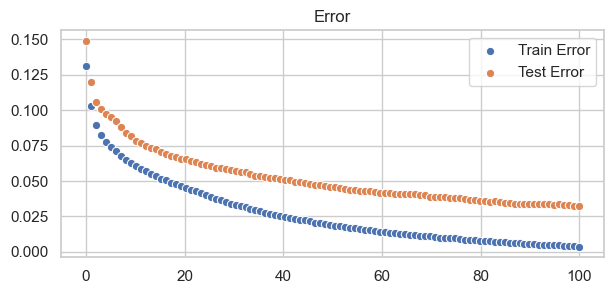

In [8]:
iter_len = len(infer['validation_0']['merror'])
x_axis = np.linspace(0, iter_len, iter_len)
plt.figure(figsize=(7,3),dpi=100)
plt.title('Error')
sns.scatterplot(x_axis, infer['validation_0']['merror'], label='Train Error')
sns.scatterplot(x_axis, infer['validation_1']['merror'], label='Test Error')
plt.legend()
plt.show()

#### Logloss

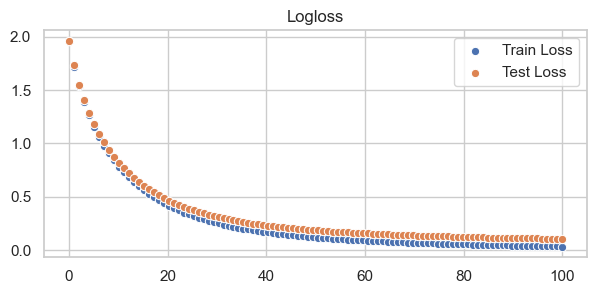

In [9]:
iter_len = len(infer['validation_0']['mlogloss'])
x_axis = np.linspace(0, iter_len, iter_len)
plt.figure(figsize=(7,3),dpi=100)
plt.title('Logloss')
sns.scatterplot(x_axis, infer['validation_0']['mlogloss'], label='Train Loss')
sns.scatterplot(x_axis, infer['validation_1']['mlogloss'], label='Test Loss')
plt.legend()
plt.show()

# 2. Xgboost with GPU Support

### **Here I will be using one  NVIDIA GTX 1080 ti** 

Build the model

In [10]:
params = { 'max_depth':5, 'objective':'binary:logistic', 'subsample':0.8,'colsample_bytree':0.8, 
          'eta':0.5, 'min_child_weight':1, "n_estimators": 400, 
          'tree_method':'gpu_hist', 'predictor':'gpu_predictor', 'gpu_id':1 }


xgb_gpu = XGBClassifier(**params)

###  Fitting the model, using both training and testing sets for model validation

In [11]:
t2 = time.time()
xgb_gpu.fit(X_train, y_train, sample_weight=None,
            base_margin=None,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric=["merror", "mlogloss"],
            early_stopping_rounds=10,
            verbose=True,
            xgb_model=None,
            sample_weight_eval_set=None,
            callbacks=None)

t3 = time.time()
xgb_gpu_t = (t3 - t2)

print('Xgboost GPU FIT time = %f secs.' %(t3-t2))

[0]	validation_0-merror:0.16738	validation_0-mlogloss:1.03762	validation_1-merror:0.17450	validation_1-mlogloss:1.05120
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-merror:0.11762	validation_0-mlogloss:0.75120	validation_1-merror:0.13250	validation_1-mlogloss:0.77231
[2]	validation_0-merror:0.09805	validation_0-mlogloss:0.57904	validation_1-merror:0.10950	validation_1-mlogloss:0.60529
[3]	validation_0-merror:0.08217	validation_0-mlogloss:0.45731	validation_1-merror:0.09620	validation_1-mlogloss:0.48801
[4]	validation_0-merror:0.07143	validation_0-mlogloss:0.37063	validation_1-merror:0.08750	validation_1-mlogloss:0.40648
[5]	validation_0-merror:0.06340	validation_0-mlogloss:0.31062	validation_1-merror:0.08130	validation_1-mlogloss:0.35056
[6]	validation_0-merror:0.05700	validation_0-mlogloss:0.26496	validation_1-merror:0.07530	validation_1-mlogloss:0

[67]	validation_0-merror:0.00000	validation_0-mlogloss:0.00370	validation_1-merror:0.02500	validation_1-mlogloss:0.07803
[68]	validation_0-merror:0.00000	validation_0-mlogloss:0.00351	validation_1-merror:0.02480	validation_1-mlogloss:0.07768
[69]	validation_0-merror:0.00000	validation_0-mlogloss:0.00338	validation_1-merror:0.02500	validation_1-mlogloss:0.07750
[70]	validation_0-merror:0.00000	validation_0-mlogloss:0.00325	validation_1-merror:0.02480	validation_1-mlogloss:0.07719
[71]	validation_0-merror:0.00000	validation_0-mlogloss:0.00313	validation_1-merror:0.02450	validation_1-mlogloss:0.07696
[72]	validation_0-merror:0.00000	validation_0-mlogloss:0.00300	validation_1-merror:0.02440	validation_1-mlogloss:0.07687
[73]	validation_0-merror:0.00000	validation_0-mlogloss:0.00290	validation_1-merror:0.02460	validation_1-mlogloss:0.07684
[74]	validation_0-merror:0.00000	validation_0-mlogloss:0.00280	validation_1-merror:0.02460	validation_1-mlogloss:0.07653
[75]	validation_0-merror:0.00000

[135]	validation_0-merror:0.00000	validation_0-mlogloss:0.00070	validation_1-merror:0.02180	validation_1-mlogloss:0.07087
[136]	validation_0-merror:0.00000	validation_0-mlogloss:0.00069	validation_1-merror:0.02190	validation_1-mlogloss:0.07082
[137]	validation_0-merror:0.00000	validation_0-mlogloss:0.00068	validation_1-merror:0.02190	validation_1-mlogloss:0.07079
[138]	validation_0-merror:0.00000	validation_0-mlogloss:0.00067	validation_1-merror:0.02200	validation_1-mlogloss:0.07077
[139]	validation_0-merror:0.00000	validation_0-mlogloss:0.00066	validation_1-merror:0.02190	validation_1-mlogloss:0.07076
[140]	validation_0-merror:0.00000	validation_0-mlogloss:0.00065	validation_1-merror:0.02180	validation_1-mlogloss:0.07086
[141]	validation_0-merror:0.00000	validation_0-mlogloss:0.00065	validation_1-merror:0.02190	validation_1-mlogloss:0.07085
[142]	validation_0-merror:0.00000	validation_0-mlogloss:0.00064	validation_1-merror:0.02200	validation_1-mlogloss:0.07088
[143]	validation_0-merro

In [12]:
%%time
y_pred_xg_gpu = xgb_gpu.predict(X_test)

Wall time: 809 ms


# Test Results

In [13]:
%%time
print("Mean Absolute Error : " + str(np.round((100*mean_absolute_error(y_pred_xg_gpu, y_test)),decimals=5, out=None))+' %')
print("accuracy_score : " + str(np.round((100*accuracy_score(y_pred_xg_gpu, y_test)),decimals=5, out=None))+' %')
print("f1_score : " + str(np.round((100*f1_score(y_pred_xg_gpu, y_test, average='macro')),decimals=5, out=None))+' %')
print("precision_score : " + str(np.round((100*precision_score(y_pred_xg_gpu, y_test, average='macro')),decimals=5, out=None))+' %')
print("recall_score : " + str(np.round((100*recall_score(y_pred_xg_gpu, y_test, average='macro')),decimals=5, out=None))+' %')


Mean Absolute Error : 8.36 %
accuracy_score : 97.81 %
f1_score : 97.7976 %
precision_score : 97.79499 %
recall_score : 97.80239 %
Wall time: 22 ms


# Plotting the Validation Losses

In [14]:
infer = xgb_gpu.evals_result()

#### Error

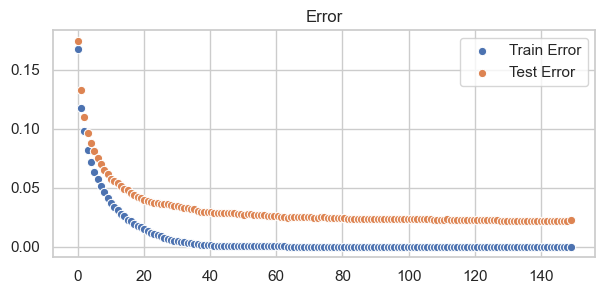

In [15]:
iter_len = len(infer['validation_0']['merror'])
x_axis = np.linspace(0, iter_len, iter_len)
plt.figure(figsize=(7,3),dpi=100)
plt.title('Error')
sns.scatterplot(x_axis, infer['validation_0']['merror'], label='Train Error')
sns.scatterplot(x_axis, infer['validation_1']['merror'], label='Test Error')
plt.legend()
plt.show()

#### Logloss

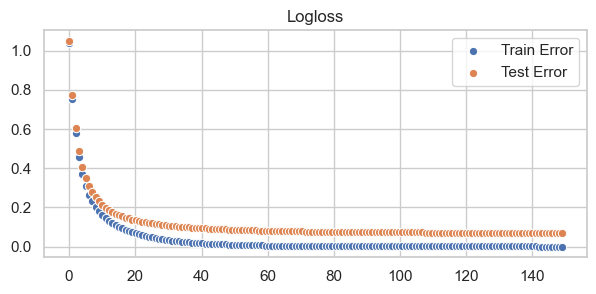

In [16]:
iter_len = len(infer['validation_0']['mlogloss'])
x_axis = np.linspace(0, iter_len, iter_len)
plt.figure(figsize=(7,3),dpi=100)
plt.title('Logloss')
sns.scatterplot(x_axis, infer['validation_0']['mlogloss'], label='Train Error')
sns.scatterplot(x_axis, infer['validation_1']['mlogloss'], label='Test Error')
plt.legend()
plt.show()

# 3. Comparison with Random Forest

### Random Forest Model 
(n_jobs = -1) uses all the 4 cores (8 threads) of the cpu

In [17]:
rf = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_depth=5,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=-1,
                            random_state=None,
                            verbose=1,
                            warm_start=False,
                            class_weight=None,
                            ccp_alpha=0.0,
                            max_samples=None)

In [18]:
t4 = time.time()
rf.fit(X_train, y_train)
t5 = time.time()
rf_t = (t5 - t4)

print('Random Forest FIT time = %f secs.' %(t5-t4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s


Random Forest FIT time = 6.724292 secs.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished


In [19]:
%%time
y_pred_rf = (rf.predict(X_test))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Wall time: 267 ms


# Test Results

In [20]:
%%time
print("Mean Absolute Error : " + str(np.round((100*mean_absolute_error(y_pred_rf, y_test)),decimals=5, out=None))+' %')
print("accuracy_score : " + str(np.round((100*accuracy_score(y_pred_rf, y_test)),decimals=5, out=None))+' %')
print("f1_score : " + str(np.round((100*f1_score(y_pred_rf, y_test, average='macro')),decimals=5, out=None))+' %')
print("precision_score : " + str(np.round((100*precision_score(y_pred_rf, y_test, average='macro')),decimals=5, out=None))+' %')
print("recall_score : " + str(np.round((100*recall_score(y_pred_rf, y_test, average='macro')),decimals=5, out=None))+' %')


Mean Absolute Error : 51.57 %
accuracy_score : 85.98 %
f1_score : 85.65927 %
precision_score : 85.5948 %
recall_score : 86.59872 %
Wall time: 19 ms


# Comapring Results

In [21]:
index = ['Xgboost with CPU', 'Xgboost with GPU', 'Random Forest']

columns = ['Model fit time (secs)','Mean_absolute_error', 'Accuracy_score', 'F1_score', 'Precision_score', 'Recall_score']
df = pd.DataFrame(index=index, columns=columns)
df = df.fillna(0)

In [22]:
df['Model fit time (secs)'] = [xgb_cpu_t, xgb_gpu_t, rf_t]
df['Mean_absolute_error'] = [100*mean_absolute_error(y_pred_xg_cpu, y_test),
                             100*mean_absolute_error(y_pred_xg_gpu, y_test),
                             100*mean_absolute_error(y_pred_rf, y_test)]

df['Accuracy_score'] = [100*accuracy_score(y_pred_xg_cpu, y_test),
                             100*accuracy_score(y_pred_xg_gpu, y_test),
                             100*accuracy_score(y_pred_rf, y_test)]

df['F1_score'] = [100*f1_score(y_pred_xg_cpu, y_test, average='macro'),
                             100*f1_score(y_pred_xg_gpu, y_test, average='macro'),
                             100*f1_score(y_pred_rf, y_test, average='macro')]

df['Precision_score'] = [100*precision_score(y_pred_xg_cpu, y_test, average='macro'),
                             100*precision_score(y_pred_xg_gpu, y_test, average='macro'),
                             100*precision_score(y_pred_rf, y_test, average='macro')]

df['Recall_score'] = [100*recall_score(y_pred_xg_cpu, y_test, average='macro'),
                             100*recall_score(y_pred_xg_gpu, y_test, average='macro'),
                             100*recall_score(y_pred_rf, y_test, average='macro')]

In [23]:
df

,Model fit time (secs),Mean_absolute_error,Accuracy_score,F1_score,Precision_score,Recall_score
Xgboost with CPU,715.723762,11.82,96.77,96.748683,96.744808,96.756988
Xgboost with GPU,80.715255,8.36,97.81,97.797602,97.794991,97.802394
Random Forest,6.724292,51.57,85.98,85.659274,85.594799,86.598721


# Conclusion

**Thus it can be seen that, Xgboost ran on the GPU gives the best test results and uses considerably less amount of time than its CPU's counterpart. On the other hand, Random forest though uses the least time but with the expense of huge losses.**